# K Nearest Neighbors

Experiment freely. This is a hands-on (brains off!) experience!

In [23]:
working_dir <- '~' ## If running locally, replace with the path to the folder in which you saved the notebooks (e.g. 'C:/Documents/mlTeachings') 
setwd(working_dir)

In [51]:
source('src/lib.R')
df = get_partitioned_df()
info = getModelInfo()
data_name = 'spirals'

Loading required package: rattle
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'rattle'"Loading required package: Metrics
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'Metrics'"Loading required package: AUC
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'AUC'"

This is what KNN at its simplest looks like:

$$ \Pr(Y = j | X = x_0) = \frac{1}{K}\sum_{k \in N_0}{I(y_k = j)}$$

Which basically means that the probability of an observation $x_0$ to belong to class $j$, is the weighed sum of the "votes" given by the *k* closest points of class $j$. That said, the more observations in $N_0$ (the closest *k* neighbors) belong to the class $j$ the more likely it is for $x_0$ to belong to class $j$ as well.

Ok fine! Let's test this model with **CARET** on one of the toy datasets....first choose one of the datasets:

In [52]:
df %>% names

[1] "full"    "normal"  "circles" "spirals" "linear"

In [53]:
data_name <- "spirals"

Then, choose the number of neighbors to consider in the model:

In [54]:
k <- 3

In [55]:
model = train(y = df[[data_name]]$y_train$class,
              x = df[[data_name]]$x_train,
              method = "kknn",
              ks = k,
              trControl = trainControl(classProbs =  TRUE)
)

Warning message:
"Non Lab interpolation is deprecated"

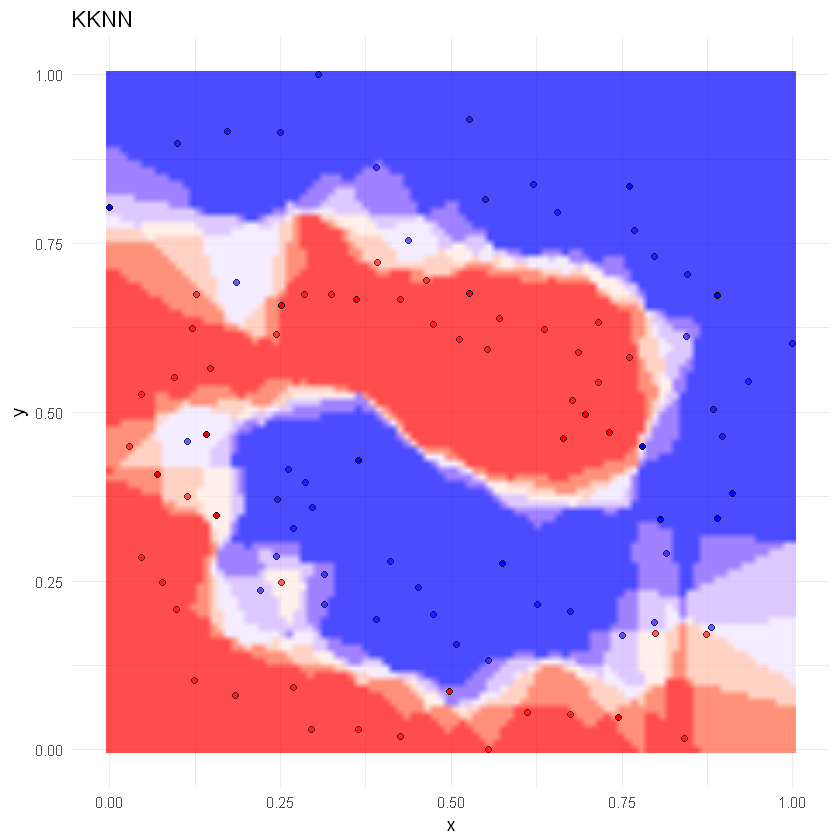

In [56]:
## prepare the prediction

from <- 0
to <- 1
n <- 100
grid_df <- expand.grid(
  x = seq(from, to, length.out = n),
  y = seq(from, to, length.out = n)
)

grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)

## prepare the dataset

data_df <- lapply(
  data_name,
  function(data_name) {
    df <- df[[data_name]] 
    rbind(
      df$full_train %>% mutate(partition = "train"),
      df$full_val %>% mutate(partition = "val")
    )
  }
) %>% bind_rows

## plot the data
ggplot() + 
  geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
  scale_fill_gradient2(low = "blue", mid = "white",
                       high = "red", midpoint = 0.5, space = "rgb",
                       na.value = "grey50", guide = "colourbar") +
  geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
  scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
  theme_minimal() + ggtitle(model$method %>% toupper) +
  theme(legend.position = "none")

Pretty neat, isn't it? Well, a close look tells us that there are some red points in the bottom right corner that are classified as belonging to the blue zone. This is not good. What can we do?

### Tweak KNN hyper parameters

In [57]:
model = train(y = df[[data_name]]$y_train$class,
              x = df[[data_name]]$x_train,
              method = 'kknn',
              ks = 5,
              trControl = trainControl(classProbs =  TRUE)
)

Warning message:
"Non Lab interpolation is deprecated"

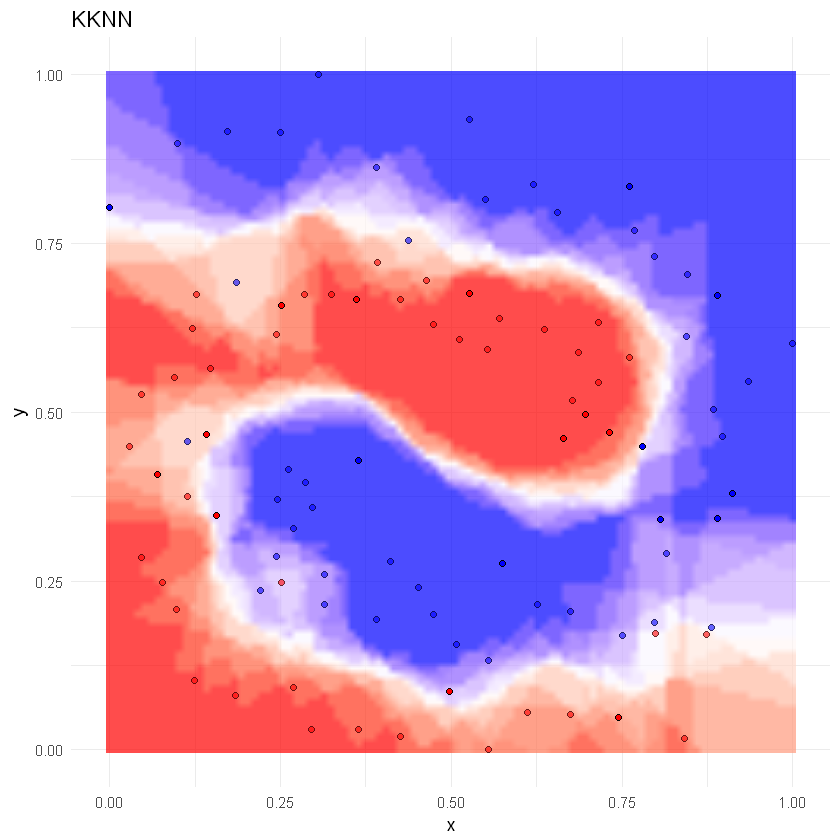

In [58]:
plot_model(df, data_name, model)

That's way better! Can you see how the model is now much more confident on the position of the observations in the bottom right corner?

## Kernels + a few things about distances

Disclaimer: this is nowere close to a formal explanation of the concept of kernel, and a mathematician would probably kill me for the things I will be saying below.

But I hope it can be somehow helpful.

In the standard KNN algorithm all the neighbors have the same power in defining the output class. However in some cases may be very efficient to introduce a *weighting scheme* to give more discriminant power the neighbors that are more similar to the to-classify observation $x_0$.
 
To parametrize the *weighting scheme* we can introduce a so-called *kernel function* $K: \mathbb{R^+} \rightarrow \mathbb{R^+}$ that satisfies two conditions:
 
* $K(d)$ gets its maximum for $d = 0$
* $K(d)$ decreases monotonously as $d \rightarrow +\infty$
 
Using this kernel function we can predict the class of $x_0$ given the $k$ neighbors in $N_0$ as:
 
$$ p = \operatorname{argmax}_j\left\{\sum_{k \in N_0}{K(d(x_0, y_k))I(y_k = j)} \right\} $$
 
Or define the probability:
 
$$\Pr(Y = j | X = x_0) = \frac{\sum_{k \in N_0}K(d(x_0, y_k))I(y_k = j)}{\sum_{k \in N_0}K(d(x_0, y_k))}$$
 
Where:
* $I$ is an *indicator function* which takes value $+1$ if the istance belongs to the first class and $-1$ otherwise.
* $d(x,y)$ is a distance function like the *euclidean distance*. However in different settings a different measure of distance may turn out being more effective. The *Minkowski* distance is a generalization of the concept of distance:
 
$$d\left(x,y\right)=\left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p}$$
 
When $p = 2$ we have the *euclidean distance*, when $p = 1$ we have th *manhattan distance* and so on...
 
The choice of the *distance* function is a *hyperparameter* of the *Kernelised K-Nearest Neighbor*.
 
The other *hyperparameter* added by the KNN *kernelisation* regards the choice of kernel function $K(d)$.
 
These are three kernel function examples.
1. Rectangular kernel (standard KNN kernel)
2. Gaussian kernel
3. Parabolic kernel
 
![Standard KNN Kernel](../fig/rectangular_kernel.png "title-1") ![Gaussian Kernel](../fig/gaussian_kernel.png "title-2")![Epanechnikov (alias parabolic) Kernel](../fig/epanechnikov_kernel.png "title-2")

To manipulate both the *type of kernel* and the *type of distance* in the hyperparameter setting phase, we must use a different implementation of the knn algorithm, obiouvsly availlable in CARET

In [59]:
## choose the ML algorithm

algorithm = 'kknn' # alias Kernelized KNN

info[[algorithm]]$parameters

parameter,class,label
kmax,numeric,Max. #Neighbors
distance,numeric,Distance
kernel,character,Kernel


In [60]:
k = 10

hyperparameters = data.frame('kmax' = 5,
                             'distance' = 0.1,   # coefficent p of the Minkowski distance. Set to two reduces to euclidean distance.
                             'kernel' = c('epanechnikov') # rectangular is the equivalent of the standard KNN
                            )

In [61]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
              x = df[[data_name]]$x_train,
              method = algorithm,
              tuneGrid = hyperparameters,
              trControl = trainControl(classProbs =  TRUE)
)

Warning message:
"Non Lab interpolation is deprecated"

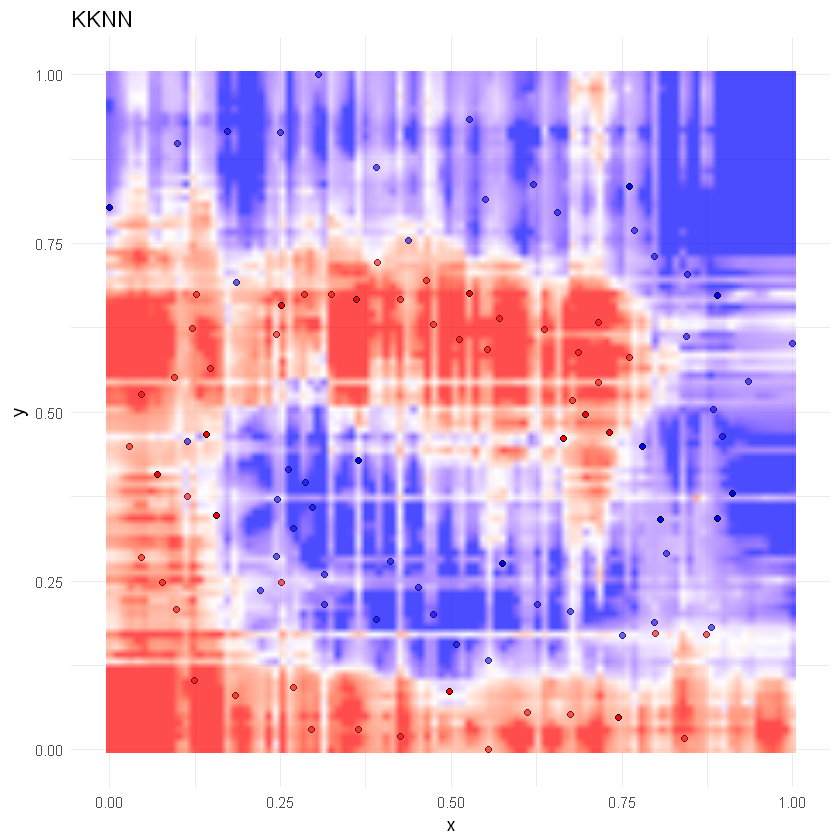

In [62]:
plot_model(df, data_name, model)

Whoops! Any better? Perhaps, but this looks like it's overfitting. Indeed, in our extremely simplified setting (generated data and only two features), both the kernel trick and non-Euclidean distances are not quite necessary.

Try instead further reducing the number of k neighbors... #simpleisbetter

Anyway, let's try something else.